In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pdb
import cv2
from copy import deepcopy
import torch

In [ ]:
# optical parameters, unit is meter
zs = 0.01 
pp = 1e-6
Sigma = 1e-3
dSigma = 3e-4
zf = 2
rho = 1/zf + 1/zs
lower_threshold = 4/255
upper_threshold = 8/255
alpha = 50000
drho = 0.00
drho_VP = 0.21

0.0 1.0


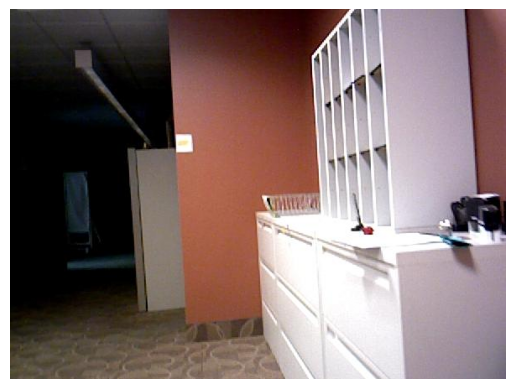

In [28]:
img = cv2.imread('scene.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255
print(img.min(), img.max())
plt.axis('off')
plt.imshow(img)

In [29]:
def add_poisson_noise(image, alpha=1):
    """Adds Poisson noise to an image.

    Args:
        image: A NumPy array representing the image.

    Returns:
        A NumPy array representing the noisy image.
    """
    # Ensure the image is a float type
    image = image.astype(np.float64)

   
    
    #Determine max value for scaling
    scaled_image = image * alpha
    scaled_image = np.clip(scaled_image, 0, alpha)
    # print(scaled_image.min(), scaled_image.max())
    # Generate Poisson noise with the scaled image as the mean
    noisy_image = np.random.poisson(scaled_image)

    
    # Scale back to the original range and convert to the original data type
    noisy_image = np.minimum(noisy_image / alpha, 1.0)

    return noisy_image

def grayscale(x):
    R = x[..., :, :, 0:1]
    G = x[..., :, :, 1:2]
    B = x[..., :, :, 2:3]
    return 0.2126*R + 0.7152*G + 0.0722*B
    
def psf(z, rho, Sigma):
    sigma = ((1/z - rho) * zs + 1) / pp * Sigma
    sigma = np.abs(sigma)
    # print(z, rho, Sigma, sigma)
    if sigma < 0.1:
        return np.array([[1]])
    xx, yy = np.meshgrid(np.arange(-3*sigma, 3*sigma+1e-6), np.arange(-3*sigma, 3*sigma+1e-6))
    return np.exp(-(xx**2 + yy**2) / (2 * sigma**2)) / (2 * np.pi * sigma**2)


def psf_set(z):
    R_HP_psf = psf(z, rho - drho, Sigma)
    G_HP_psf = psf(z, rho, Sigma)
    B_HP_psf = psf(z, rho + drho, Sigma)

    R_VP_psf = psf(z, rho - drho + drho_VP, Sigma)
    G_VP_psf = psf(z, rho + drho_VP, Sigma )
    B_VP_psf = psf(z, rho + drho + drho_VP, Sigma)

    R_DP_psf = psf(z, rho - drho, Sigma + dSigma)
    G_DP_psf = psf(z, rho, Sigma + dSigma)
    B_DP_psf = psf(z, rho + drho, Sigma + dSigma)

    return [R_HP_psf, G_HP_psf, B_HP_psf, R_VP_psf, G_VP_psf, B_VP_psf, R_DP_psf, G_DP_psf, B_DP_psf]

def visualize_psf_set(z):
    psf_set_img = psf_set(z)
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    for i in range(len(psf_set_img)):
        ax = axes[i // 3, i % 3]
        ax.axis('off')
        ax.imshow(psf_set_img[i], cmap='gray')
    plt.show()

def render_img(img, z, mode='color'):
    # print('Rendering image at z =', z)
    psf_set_img = psf_set(z)
    img_HP = np.zeros_like(img) # horizontal linear polarization
    img_VP = np.zeros_like(img) # vertical linear polarization
    img_DP = np.zeros_like(img) # diagonal linear polarization
    for i in range(3):
        img_HP[:,:,i] = cv2.filter2D(img[:,:,i], -1, psf_set_img[i])
        img_HP[:,:,i] = add_poisson_noise(img_HP[:,:,i], alpha)
        img_VP[:,:,i] = cv2.filter2D(img[:,:,i], -1, psf_set_img[i+3])
        img_VP[:,:,i] = add_poisson_noise(img_VP[:,:,i], alpha)
        img_DP[:,:,i] = cv2.filter2D(img[:,:,i], -1, psf_set_img[i+6])
        img_DP[:,:,i] = add_poisson_noise(img_DP[:,:,i], alpha)
        
    
    if mode == 'gray':
        return grayscale(img_VP), grayscale(img_HP), grayscale(img_DP)

    return img_VP, img_HP, img_DP

def image_subtraction(img1, img2):
    return (img1 - img2)


def binarize_img(img, z):
    img_VP, img_HP, img_DP = render_img(img, z, mode='gray')
    img_processed = image_subtraction(img_HP, img_VP)
    img_processed = keep_positive(img_processed)
    img_processed = omit_small_values(img_processed, lower_threshold, upper_threshold)
    img_processed[img_processed > 0] = 1
    return img_processed


def omit_small_values(img, lower_threshold, upper_threshold):
    img[np.abs(img) <= lower_threshold] = 0 
    # img[img >= upper_threshold] = upper_threshold
    # img[img <= -upper_threshold] = -upper_threshold
    img[img >= upper_threshold] = 0
    img[img <= -upper_threshold] = 0
    return img

# def visualize_processed_img(img, z):
#     img_processed = process_img(img, z)
#     # img_processed = omit_small_values(img_processed, 0)
#     fig = plt.figure(figsize=(30, 12))
#     fig.add_subplot(2,3,1)
#     plt.axis('off')
#     plt.imshow((img_processed[:,:,0]>0)*img_processed[:,:,0], cmap='Reds',vmin=0,vmax=16)
#     plt.title('Red Positive')
    
#     fig.add_subplot(2,3,2)
#     plt.axis('off')
#     plt.imshow((img_processed[:,:,1]>0)*img_processed[:,:,1], cmap='Greens',vmin=0,vmax=16)
#     plt.title('Green Positive')

#     fig.add_subplot(2,3,3)
#     plt.axis('off')
#     plt.imshow((img_processed[:,:,2]>0)*img_processed[:,:,2], cmap='Blues',vmin=0,vmax=16)
#     plt.title('Blue Positive')

#     fig.add_subplot(2,3,4)
#     plt.axis('off')
#     plt.imshow((img_processed[:,:,0]<0)*-img_processed[:,:,0], cmap='Reds', vmin=0, vmax=16)
#     plt.title('Red Negative')

#     fig.add_subplot(2,3,5)
#     plt.axis('off')
#     plt.imshow((img_processed[:,:,1]<0)*-img_processed[:,:,1], cmap='Greens', vmin=0, vmax=16)
#     plt.title('Green Negative')

#     fig.add_subplot(2,3,6)
#     plt.axis('off')
#     plt.imshow((img_processed[:,:,2]<0)*-img_processed[:,:,2], cmap='Blues', vmin=0, vmax=16) 
#     plt.title('Blue Negative')

#     return img_processed


def keep_positive(img):
    img[img<0] = 0
    return img

def sparse_color(img, sparsity=0.001):
    random_kernel = np.random.rand(*img[:,:,0].shape)
    return img*(random_kernel<sparsity)[:,:,None]
    # img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # H=img_hsv[:,:,0]
    # S=img_hsv[:,:,1] 
    # V=img_hsv[:,:,2]
    # V[random_kernel > sparsity] = 0
    # # V[random_kernel < sparsity] = 128
    # img_sparse = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    # return img_sparse

def pixelate_sparse_color(img_sparse):
    kernel = np.ones((11,1))
    img_sparse = cv2.filter2D(img_sparse, -1, kernel)
    img_sparse = cv2.filter2D(img_sparse, -1, kernel.T)
    return img_sparse

def cod(img_VP, img_HP, img_DP, z):
    img_VP = img_VP.astype(float)
    img_HP = img_HP.astype(float)
    img_DP = img_DP.astype(float)
    kernel_dim = 11
    kernel = np.ones((kernel_dim,1)) / kernel_dim

    Irho = img_VP - img_HP
    ISigma = img_DP - img_HP

    x = cv2.filter2D(Irho**2, -1, kernel)
    x = cv2.filter2D(x, -1, kernel.T)
    y = cv2.filter2D(Irho * ISigma, -1, kernel)
    y = cv2.filter2D(y, -1, kernel.T)
    x = x[::kernel_dim, ::kernel_dim]
    y = y[::kernel_dim, ::kernel_dim]

    idx = np.random.randint(0, x.flatten().shape[0], 10000)
    x = x.flatten()[idx]
    y = y.flatten()[idx]

    plt.plot(x, y, '.', markersize=0.1)
    plt.xlabel('Irho')
    plt.ylabel('ISigma')
    plt.title('Depth = {:.2f}m'.format(z))
    plt.grid()
    plt.xlim(0,0.04)
    plt.ylim(-.02,.02)

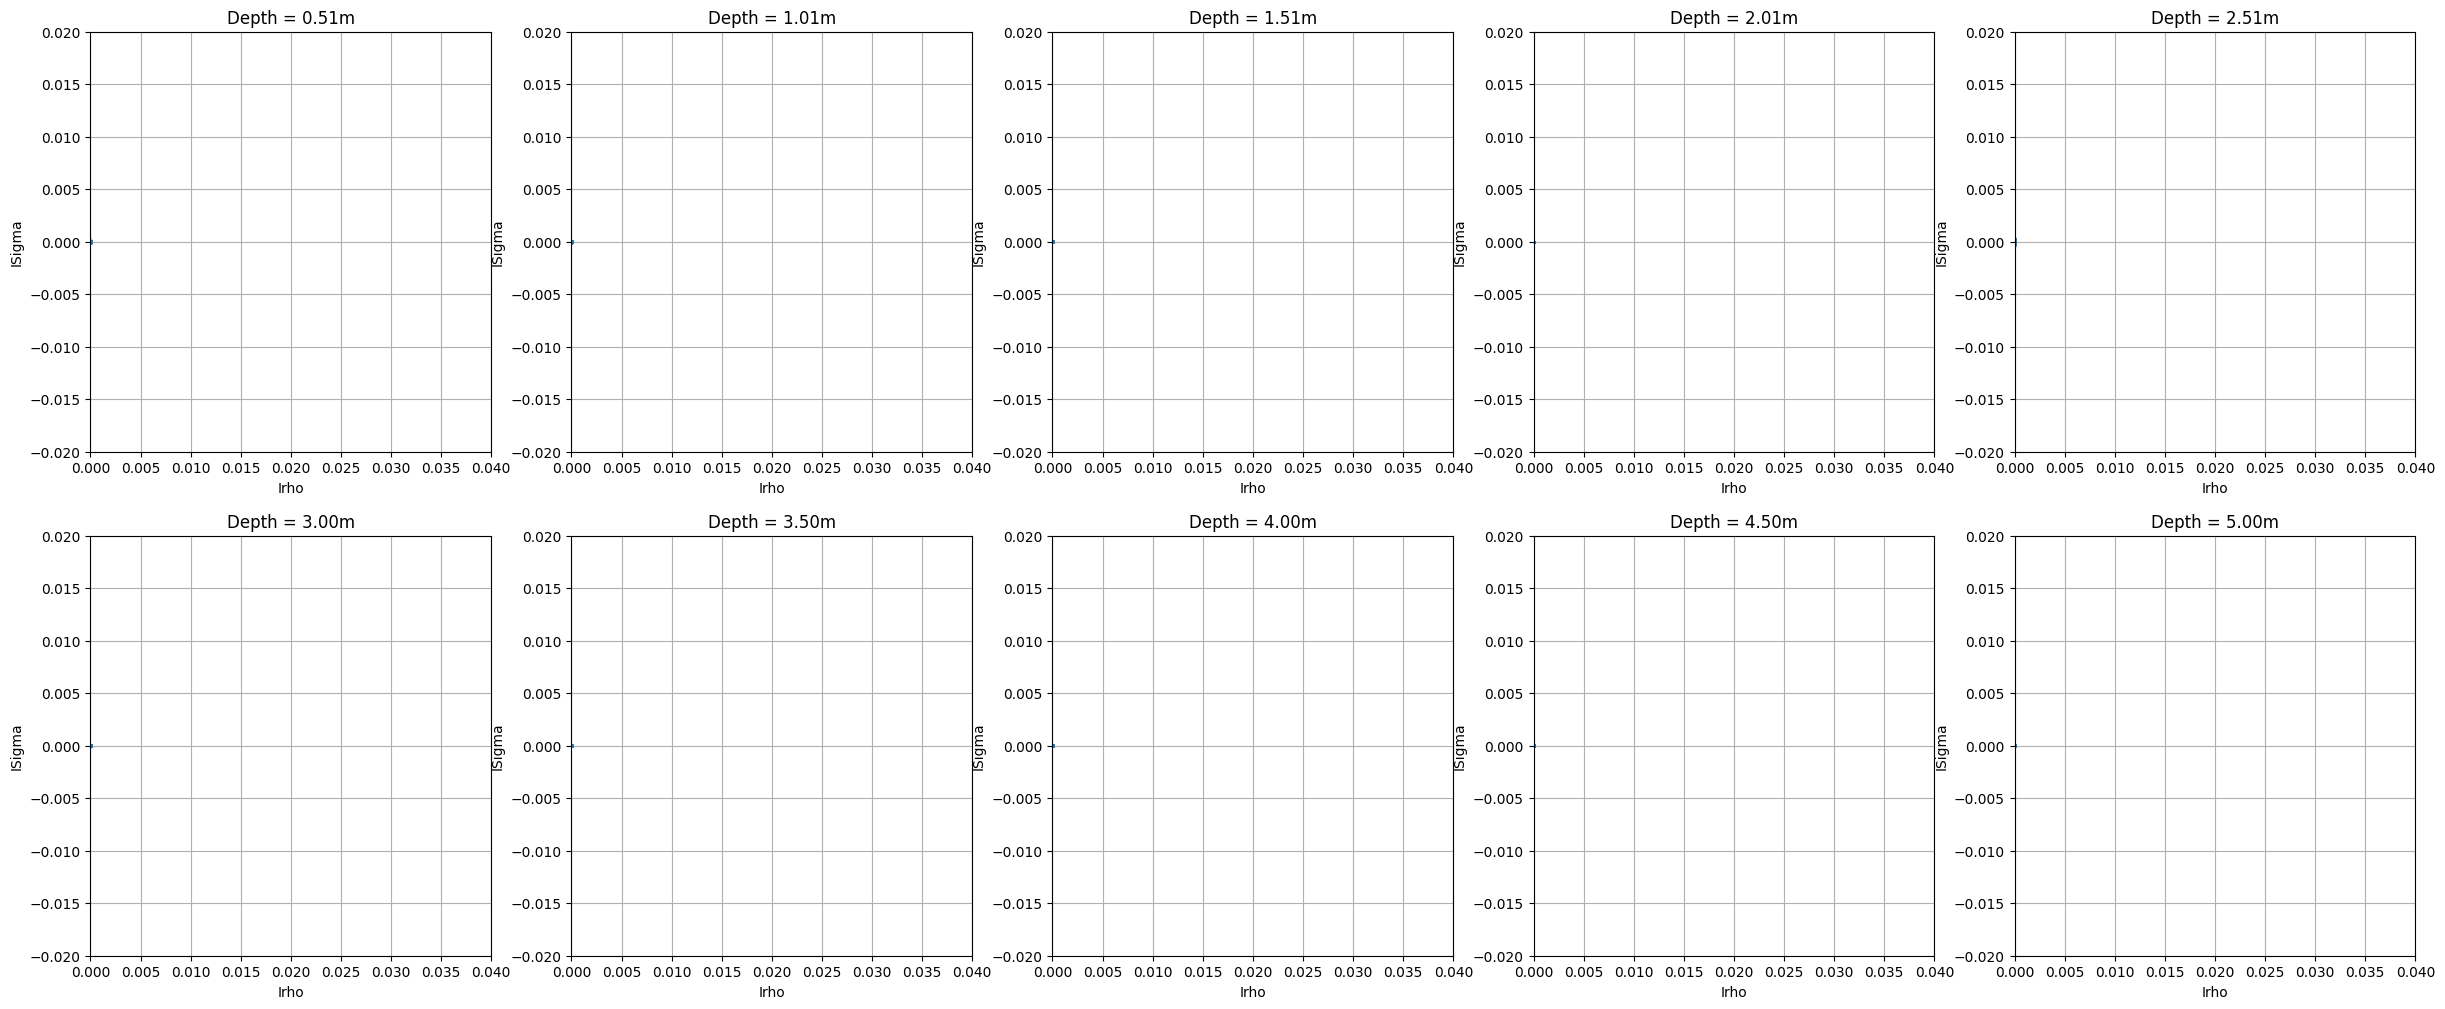

In [30]:
all_z = np.linspace(0.51, 5, 10)
fig = plt.figure(figsize=(30, 12))
for i in range(len(all_z)):
    fig.add_subplot(2, 5, i + 1)
    img_VP, img_HP, img_DP = render_img(img, all_z[i], 'gray')
    cod(img_VP, img_HP, img_DP, all_z[i])

(-0.5, 590.5, 440.5, -0.5)

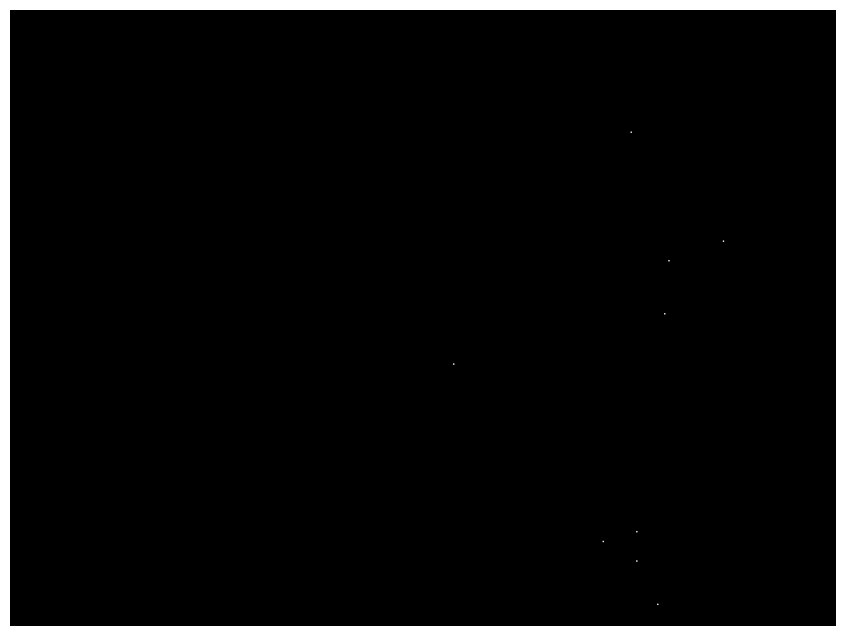

In [31]:
img_binarized = binarize_img(img, 4)
plt.figure(figsize=(12, 8))
plt.imshow((img_binarized), cmap='gray')
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.74964].


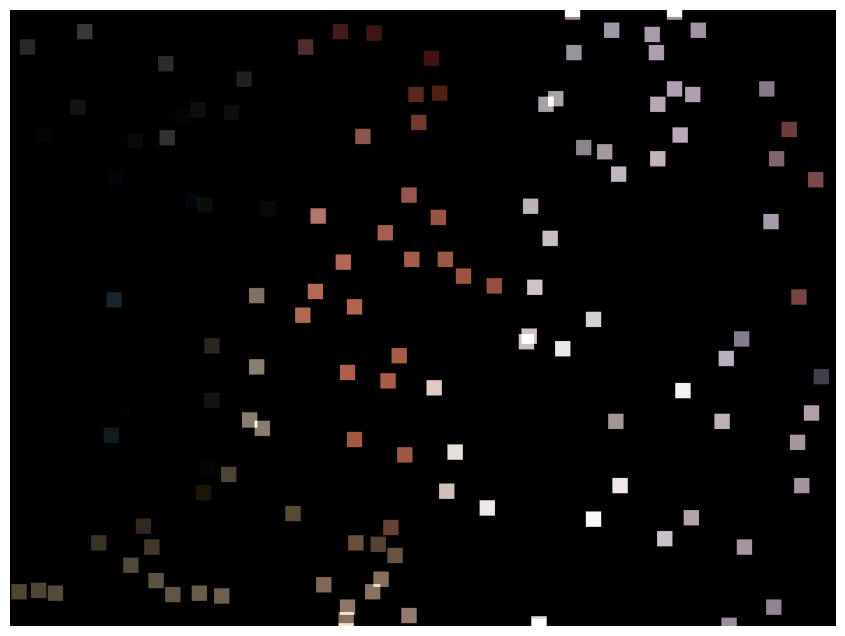

In [21]:
# sparse color
img_VP, _, _ = render_img(img, 4)
img_sparse = sparse_color(img_VP, 0.0005)
plt.figure(figsize=(12,8))
plt.imshow(pixelate_sparse_color(img_sparse))
plt.axis('off')
plt.show()

0.0 1.0


1.0

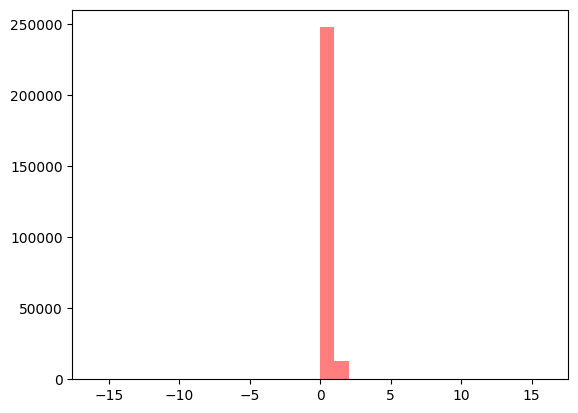

In [25]:
img_processed = binarize_img(img, 4)
print(img_processed.min(), img_processed.max())
density = plt.hist(img_processed.flatten(), bins=32, range=[-16, 16], color='r', alpha=0.5)
np.sum(density[0]) / img_processed.flatten().size

TypeError: `bins` must be an integer, a string, or an array

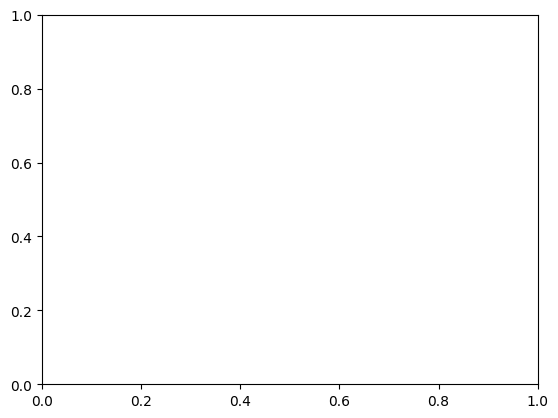

In [26]:
st = -upper_threshold
ed = upper_threshold
num = ed - st
density = plt.hist(img_processed.flatten(), bins=num, range=[st, ed], color='r', alpha=0.5, density=True)
print(density[0])

In [332]:
import random
import string
# generate the code that represent the frequency of the num numbers
random = ''.join([random.choice(string.ascii_letters) for n in range(num)])
print(random)

zRrHoHLDIrZYNKYlDhvCytvWWuKvXjMstmDXsQfFcKXotbeItNALErmTcYuoIqOb


In [333]:
def run_length_encode(seq):
    """
    Encodes `seq` using a variant of run-length encoding.
    - If a value repeats more than 2 times consecutively, store as (value, count).
    - Otherwise, store the values individually (or repeated twice) without a count.
    """
    if not seq:
        return []
    
    encoded = ""
    current_val = seq[0]
    current_count = 1
    
    for x in seq[1:]:
        if x == current_val:
            current_count += 1
        else:
            # Close out the previous run
            if current_count > 2:
                encoded = encoded + str(current_count) + current_val
            else:
                # Just append the value(s) for smaller runs
                for _ in range(current_count):
                    encoded += current_val            
            # Reset counters for the new value
            current_val = x
            current_count = 1
    
    # Handle the final run
    if current_count > 2:
        encoded += str(current_count) + current_val
    else:
        # Just append the value(s) for smaller runs
        for _ in range(current_count):
            encoded += current_val      
    
    return encoded

    

In [12]:
img_processed.flatten().min()

-7

In [13]:
np.random.seed(0)
sample_code = ''.join([random[i] for i in (img_processed+higher_threshold).flatten()])
print(sample_code)

eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee

In [14]:
rle_code = run_length_encode(sample_code)
print(rle_code)

3501epeepeepeep52eo3eooxxexmeemeem3eo3508epeepeeppeppeppeppeppep43eo5exoexmxxemmemmemxem3eo3503e6peppe3pXpeppeppep47eooxeexmxmemmeemeexee3xeo3500epe6pe3pXppXpeXpeXpeppep37eoeeoeoxoe3xmemmemmeemeemeemxeeox3493epeepee6pXppKppKppXppXppXpepp36eoeeo3eooxee3xmemmeem5emmexemxoxeeo3487epee12pXppXppKXpKppXpeXpepp36eoeeoeexooxexmmxmeemeemeemeemxmxox3eoeo3484epee12pXppXppKXpKppKppXXeppepp36eo5exeexxememmemmeemeemmememxex5eo3480eppeepe10pXppXppKXpeXpKXpKppXpeppepp40eooxeemmxmemmeemeemeexmmeom3eoeoo3477epep3epe10pXppXppXppKXpKXpKXpKppXpeppepp33eo5exooxexxmxmeememmee3mxxmeoxoeeoeo3468ep3ep3e7pe9pXppXppXXpKppKXpKXpKXeKpeppepp33eo8exeo3xmemmeemeemeemxmxemeexeeoeeo2482ep8ep5ep970eppee4pee9pXppXppXppKppKXpKXpeXpeXpXX6peep30eoeeo6eooxeemmxmemmeemeemmexxmeox3eoeo31ep5ep2447epeepeepeepeep974epee15pXppXppKXpKXpKXpeXpeXpKXpKpeppepp33eoeeo5exooxeemexeem6e3mxemeoxoeoo30epeepeep2438epeep989ep4eppe16pXppXppKppKppeXpKXpKppKXpKpeppepp33eoeeo3eooxeexmxeemm5emeemmemem3eoeo31epeep2444ep995e15pXppXppXppKppKppKXpeXpKXe